In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf
import seaborn as sns 

from sklearn.cross_decomposition import PLSRegression
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from scipy.stats import gaussian_kde 

In [2]:
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")


# THIS pulls sector and subsector info either localy if it's cached or from the api

API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')


In [3]:
tickers = df_sp500["symbol"].dropna().unique().tolist()

In [4]:
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))


def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]
            price_date = price_data[0].get("date")  # trading date

            # Get latest annual income statement
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")
            report_date = income_data[0].get("date")  # fiscal period end date

            records.append({
                "symbol": ticker,
                "price": price,
                "price_date": price_date,
                "eps": eps,
                "netIncome": net_income,
                "date": report_date
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)


price_earnings_df = fetch_price_and_earnings(tickers, output_file)
print(price_earnings_df.columns)
print(price_earnings_df.shape)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json
Index(['symbol', 'price', 'price_date', 'eps', 'netIncome', 'date'], dtype='object')
(503, 6)


In [5]:
#CLEANS AND TAKES LOG OF THE PE DATA

# Only keep rows with positive EPS
pe_data = price_earnings_df[price_earnings_df["eps"] > 0].copy()

# Compute log(PE)
pe_data["log_PE"] = np.log(pe_data["price"] / pe_data["eps"])

# Print row count for reference
print(pe_data.shape)

(480, 7)


In [6]:
# FETCHES INCOME STATEMENT AND BS STATEMENT AND CF STATEMENT
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    # "RECORDS HERE IS A LIST OF STRINGS NOT A DF"
    return records

# AT THIS POINT INCOME_DATA_2_YEARS IS STILL A LIST OF STRINGS STORED AS A VAR
income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# INCOME_DATA_2_YEARS IS CONVERTED TO A DF
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)


# End of fetching

In [7]:
income_data_2_years.drop(columns=["netIncome"], inplace=True, errors="ignore")

In [15]:
# --- Clean up column names (remove spaces, tabs, and backslashes) ---
for df_name, df in {
    "income_data_2_years": income_data_2_years,
    "balance_data_2_years": balance_data_2_years,
    "cashflow_data_2_years": cashflow_data_2_years,
    "pe_data": pe_data
}.items():
    df.columns = df.columns.str.strip().str.replace(r'\\', '', regex=True)
    print(f"{df_name}: cleaned column names")


income_data_2_years: cleaned column names
balance_data_2_years: cleaned column names
cashflow_data_2_years: cleaned column names
pe_data: cleaned column names


In [16]:
def count_problematic_entries(df, label):
    print(f"\n🔍 Problematic value counts for {label} statement:")
    
    def count_issues(col):
        numeric_col = pd.to_numeric(col, errors='coerce')
        return ((numeric_col.isna()) | (numeric_col == 0)).sum()

    issue_counts = df.apply(count_issues)
    filtered_counts = issue_counts[issue_counts > 0].sort_values()
    print(filtered_counts)


In [17]:
count_problematic_entries(income_data_2_years, "Income")
count_problematic_entries(balance_data_2_years, "Balance Sheet")
count_problematic_entries(cashflow_data_2_years, "Cash Flow")


🔍 Problematic value counts for Income statement:
operatingExpenses                             8
depreciationAndAmortization                   9
incomeTaxExpense                             12
costOfRevenue                                20
interestExpense                              63
totalOtherIncomeExpensesNet                  65
sellingGeneralAndAdministrativeExpenses      79
otherExpenses                               330
interestIncome                              352
generalAndAdministrativeExpenses            548
researchAndDevelopmentExpenses              605
sellingAndMarketingExpenses                 727
date                                       1006
period                                     1006
acceptedDate                               1006
fillingDate                                1006
reportedCurrency                           1006
symbol                                     1006
link                                       1006
finalLink                             

In [18]:
def sort_by_symbol_then_date(df):
    # Sort ascending by symbol, then by date (oldest first)
    return df.sort_values(["symbol", "date"], ascending=[True, True]).reset_index(drop=True)


income_sorted = sort_by_symbol_then_date(income_data_2_years)
balance_sorted = sort_by_symbol_then_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_then_date(cashflow_data_2_years)
pe_data_sorted = sort_by_symbol_then_date(pe_data)


pe_data_sorted.head(8)

,symbol,price,price_date,eps,netIncome,date,log_PE
0,A,138.70,None,4.44,1289000000,2024-10-31,3.441659
1,AAPL,257.13,None,6.11,93736000000,2024-09-28,3.739655
2,ABBV,236.56,None,2.40,4278000000,2024-12-31,4.590733
3,ABNB,121.49,None,4.19,2648000000,2024-12-31,3.367131
4,ABT,132.99,None,7.67,13402000000,2024-12-31,2.852957
5,ACGL,89.08,None,11.47,4312000000,2024-12-31,2.049800
6,ACN,244.34,None,12.29,7678433000,2025-08-31,2.989775
7,ADBE,351.48,None,12.44,5560000000,2024-11-29,3.341236


In [19]:
#DOUBLE CHECK THE ECISION TO ADD A CONSTANT... ELONGATING THE TAIL OF THE DISTRIBUTION
# DATA PROVIDER PUTS "0" FOR ANY LINE ITEM THAT DOESN'T EXIST IN THE FINANCIAL STATEMENT... ADDING THE CONSTANT THEN RETURNS A SMALL VALUE WHICH IN TURN 
#ALLOWS FOR A HUGE LOG CHANGE OUTLIER IF THAT LINE ITEM IN THE NEXT FINANCIALS STATEMENT IS ANYHTING OTHER THAN 0?

def compute_log_change(df, constant=1e-3, drop_first=True):
    """
    Compute log-differences for year-over-year growth of financial statement items.
    Keeps 'symbol' and 'date' columns.

    Parameters
    ----------
    df : pd.DataFrame
        Must include 'symbol' and 'date' columns, sorted by both.
    constant : float
        Small stabilizing constant for log transform.
    drop_first : bool
        Whether to drop the first row per symbol (NaN after diff).
    """
    df = df.copy()
    # Numeric part
    num_df = df.select_dtypes(include=[np.number])
    log_df = np.log(np.abs(num_df) + constant)
    log_diff = log_df.diff()

    # Rename to show log-change
    log_diff.columns = [f"{col}_logchg" for col in log_diff.columns]

    # Combine with non-numeric columns
    result = pd.concat([df[["symbol", "date"]], log_diff], axis=1)

    if drop_first:
        # Drop the first row per symbol (which has NaN diffs)
        result = result.groupby("symbol", group_keys=False).apply(lambda g: g.iloc[1:])

    return result.reset_index(drop=True)


# --- Apply grouped by symbol ---
income_log_change = (
    income_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)

balance_log_change = (
    balance_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)

cashflow_log_change = (
    cashflow_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)


In [20]:
def count_zeros_nans_logchg(df):
    # Keep only numeric columns that end with "_logchg"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_logchg")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_logchg(income_log_change)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_logchg(balance_log_change)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_logchg(cashflow_log_change)

# the purpose here is to make it easy to identify which line items (columns) are fully filled out from our sample so that we are only grabbing columns (features)
# that are likely to be filled out by the stock under consideration, cause ultimately after we find a regression that has explanatory power... we can still only apply it 
# to the stock under consideration if it has the same line items filled out 
# the 503 nans is a result of the .pct change method that we used which creates a nan on every other row

Income 0/NaN counts per YoY column:
                                                zeros  nans
revenue_logchg                                      0     0
grossProfit_logchg                                  0     0
costAndExpenses_logchg                              0     0
ebitda_logchg                                       0     0
ebitdaratio_logchg                                  0     0
operatingIncome_logchg                              0     0
operatingIncomeRatio_logchg                         0     0
incomeBeforeTax_logchg                              0     0
incomeBeforeTaxRatio_logchg                         0     0
netIncomeRatio_logchg                               0     0
eps_logchg                                          1     0
epsdiluted_logchg                                   1     0
operatingExpenses_logchg                            4     0
depreciationAndAmortization_logchg                  5     0
costOfRevenue_logchg                                7     0
inco

In [22]:
for name, df in dfs.items():
    print(f"{name}: {df.shape}")
    print("Columns:", df.columns.tolist())
    print("-" * 60)


income_post_nans: (27, 2)
Columns: ['zeros', 'nans']
------------------------------------------------------------
balance_post_nans: (44, 2)
Columns: ['zeros', 'nans']
------------------------------------------------------------
cashflow_post_nans: (30, 2)
Columns: ['zeros', 'nans']
------------------------------------------------------------
pe_data: (480, 7)
Columns: ['symbol', 'price', 'price_date', 'eps', 'netIncome', 'date', 'log_PE']
------------------------------------------------------------


In [23]:
def add_symbol_date(df_dict):
    """
    Adds a 'symbol_date' column to each DataFrame in df_dict.
    Prints the columns and shape of each updated DataFrame.
    
    Parameters:
    df_dict : dict
        Dictionary of DataFrames keyed by variable names (strings)
    
    Returns:
    None (updates DataFrames in place)
    """
    for name, df in df_dict.items():
        df["symbol_date"] = list(zip(df["symbol"], df["date"]))
        print(f"{name}: columns =  shape = {df.shape}")


# Usage
dfs = {
    "income_post_nans": income_log_change,
    "balance_post_nans": balance_log_change,
    "cashflow_post_nans": cashflow_log_change,
    "pe_data": pe_data
}

add_symbol_date(dfs)

income_post_nans: columns =  shape = (503, 30)
balance_post_nans: columns =  shape = (503, 47)
cashflow_post_nans: columns =  shape = (503, 33)
pe_data: columns =  shape = (480, 8)


In [35]:
common_pairs = (
    set(income_log_change["symbol_date"])
    & set(balance_log_change["symbol_date"])
    & set(cashflow_log_change["symbol_date"])
    & set(pe_data["symbol_date"])
)

In [36]:
def filter_by_common_pairs(df, common_pairs):
    """
    Keep only rows where the 'symbol_date' is in common_pairs.
    Returns a new DataFrame.
    """
    return df[df["symbol_date"].isin(common_pairs)].copy()

income_post_nans_overlapped = filter_by_common_pairs(income_log_change, common_pairs)
balance_post_nans_overlapped = filter_by_common_pairs(balance_log_change, common_pairs)
cashflow_post_nans_overlapped = filter_by_common_pairs(cashflow_log_change, common_pairs)
pe_post_nans_overlapped = filter_by_common_pairs(pe_data, common_pairs)

print(income_post_nans_overlapped.shape)
print(balance_post_nans_overlapped.shape)
print(cashflow_post_nans_overlapped.shape)
print(pe_post_nans_overlapped.shape)

# we only want to include a ticker if we have all the financial statement items for all dataframes

(479, 30)
(479, 47)
(479, 33)
(479, 8)


In [37]:
# Step 2: Sort consistently
income_post_nans_overlapped = income_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
balance_post_nans_overlapped = balance_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
cashflow_post_nans_overlapped = cashflow_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
pe_post_nans_overlapped = pe_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)


print(
    "Cleaned and aligned shapes:", 
    income_post_nans_overlapped.shape,   
    balance_post_nans_overlapped.shape, 
    cashflow_post_nans_overlapped.shape,
    pe_post_nans_overlapped.shape,
)

Cleaned and aligned shapes: (479, 30) (479, 47) (479, 33) (479, 8)


In [40]:
def check_alignment(dfs: dict):
    """
    Check alignment of multiple DataFrames on 'symbol' and 'date'.
    Expects each DataFrame to have the same row order and columns: 'symbol', 'date'.
    
    Parameters
    
    None (prints summary of mismatches)
    """
    # Ensure equal lengths
    lengths = {name: len(df) for name, df in dfs.items()}
    if len(set(lengths.values())) > 1:
        print("⚠️ Row counts differ between DataFrames:")
        for name, length in lengths.items():
            print(f"  {name}: {length} rows")
    else:
        print(f"✅ All DataFrames have {list(lengths.values())[0]} rows")

    # Concatenate for comparison
    merged = pd.concat(
        {name: df[["symbol", "date"]].reset_index(drop=True) for name, df in dfs.items()},
        axis=1
    )

    # Compare across DataFrames
    base = list(dfs.keys())[0]  # pick first as reference
    symbol_mismatches = 0
    date_mismatches = 0

    for i in range(len(dfs[base])):
        symbols = [merged[(name, "symbol")][i] for name in dfs.keys()]
        dates   = [merged[(name, "date")][i]   for name in dfs.keys()]
        if len(set(symbols)) > 1:
            symbol_mismatches += 1
        if len(set(dates)) > 1:
            date_mismatches += 1

    print(f"Symbol mismatches: {symbol_mismatches}")
    print(f"Date mismatches:   {date_mismatches}")

    
check_alignment({
    "income": income_post_nans_overlapped,
    "balance": balance_post_nans_overlapped,
    "cashflow": cashflow_post_nans_overlapped,
    "pe": pe_post_nans_overlapped
})

✅ All DataFrames have 479 rows
Symbol mismatches: 0
Date mismatches:   0


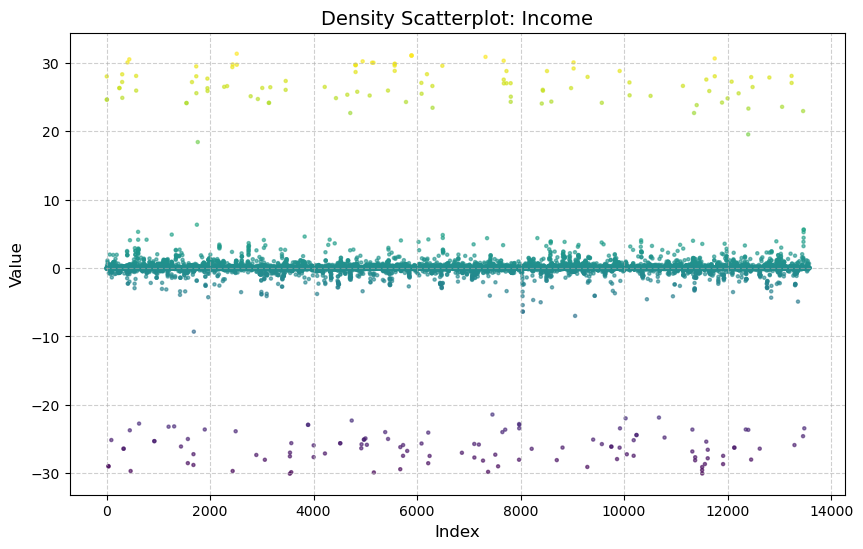

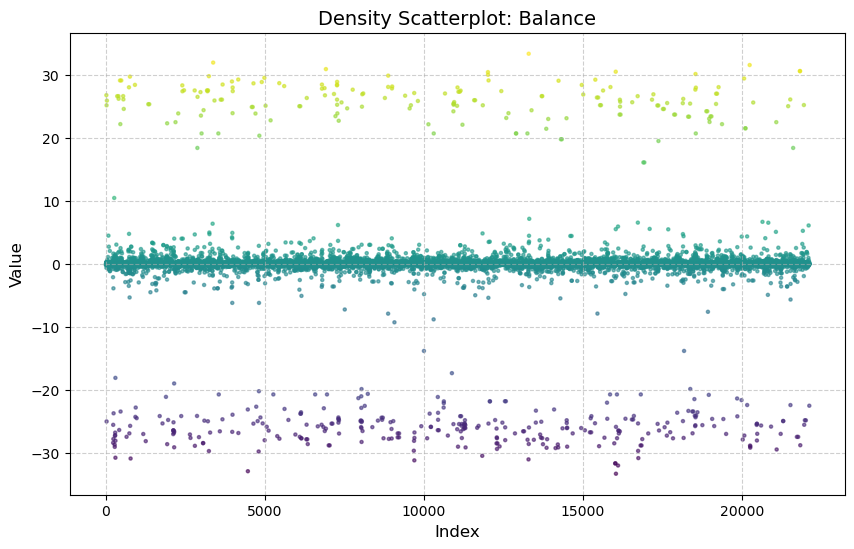

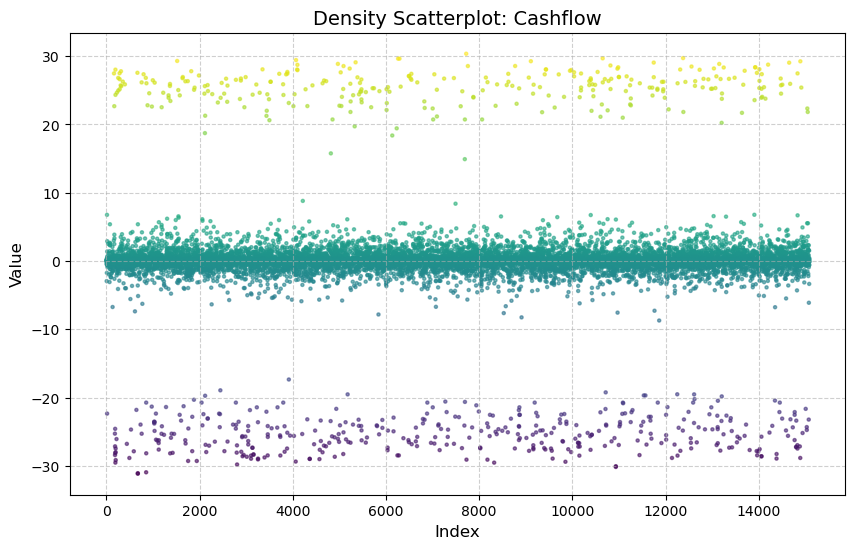

In [30]:
def outlier_check_1(df, title):
    # Flatten all numeric columns into one long vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # drop NaNs

    # Scatter vs. index, colored by density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, fill=True, color="lightblue", alpha=0.3, linewidth=0)  # background density
    plt.scatter(range(len(values)), values, 
                c=values, cmap="viridis", s=5, alpha=0.6)

    plt.title(f"Density Scatterplot: {title}", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each of your cleaned DataFrames
outlier_check_1(income_log_change, "Income")
outlier_check_1(balance_log_change, "Balance")
outlier_check_1(cashflow_log_change, "Cashflow")

#demonstrates the necessity for addressing outlier concerns 
# ONLY PURPOSE OF. THIS IS TO CONFIRM WE HAVE SERIOUS OUTLIERS THAT NEED TO BE ADDRESSED



In [44]:
def drop_high_zero_columns(df, threshold=0.05):
    """
    Drops columns with more than `threshold` proportion of zero values,
    and reports how many columns were dropped.
    """
    original_col_count = df.shape[1]

    zero_proportion = (df == 0).sum() / len(df)
    cols_to_drop = zero_proportion[zero_proportion > threshold].index

    df = df.drop(columns=cols_to_drop)
    new_col_count = df.shape[1]

    print(f"Columns before: {original_col_count}")
    print(f"Columns dropped: {len(cols_to_drop)} (>{threshold*100:.1f}% zeros)")
    print(f"Columns after: {new_col_count}")

    return df

Columns before: 30
Columns dropped: 8 (>5.0% zeros)
Columns after: 22
Columns before: 47
Columns dropped: 22 (>5.0% zeros)
Columns after: 25
Columns before: 33
Columns dropped: 15 (>5.0% zeros)
Columns after: 18


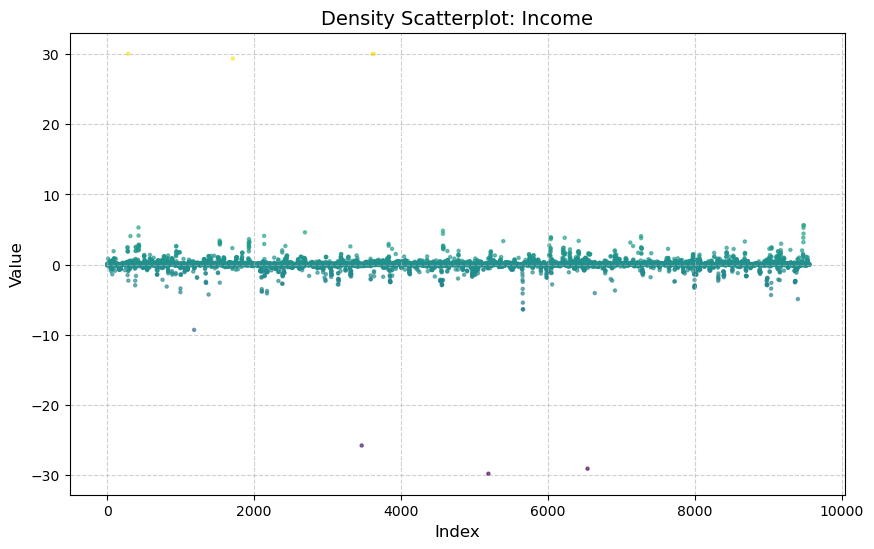

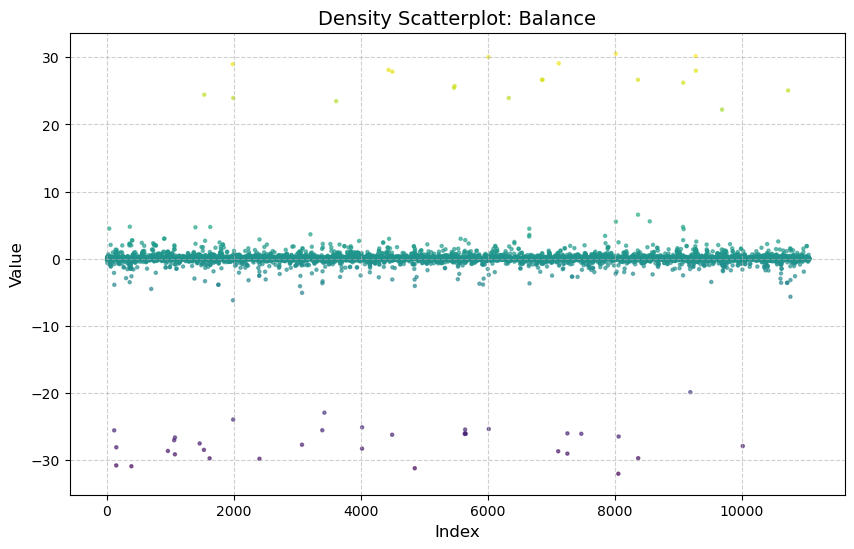

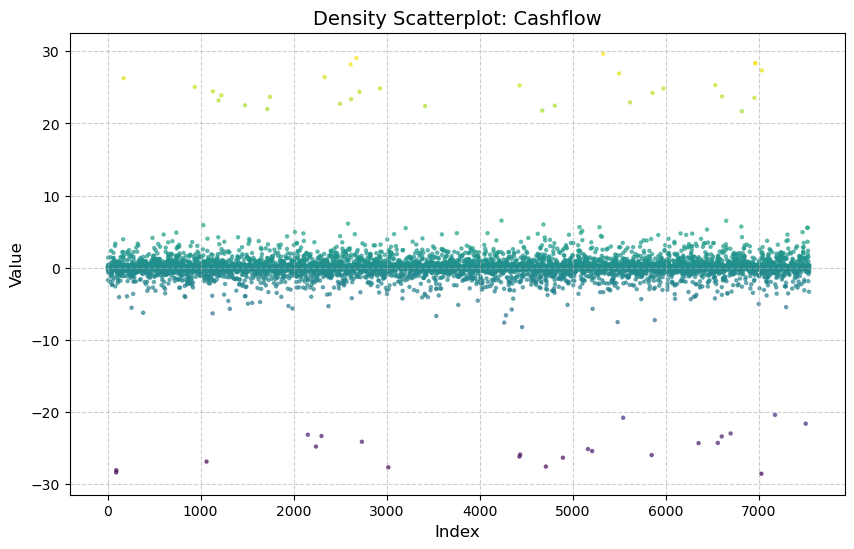

In [45]:
income_after_feature_drop = drop_high_zero_columns(income_log_change, threshold=0.05)
balance_after_feature_drop = drop_high_zero_columns(balance_log_change, threshold=0.05)
cashflow_after_feature_drop = drop_high_zero_columns(cashflow_log_change, threshold=0.05)

# Call for each of your cleaned DataFrames
outlier_check_1(income_after_feature_drop, "Income")
outlier_check_1(balance_after_feature_drop, "Balance")
outlier_check_1(cashflow_after_feature_drop, "Cashflow")

In [32]:
def drop_outlier_rows(df, threshold=10):
    """
    Drops rows where ANY numeric column has a value greater than `threshold`
    or less than `-threshold`. Prints how many rows remain afterward.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to filter.
    threshold : float
        Absolute cutoff for detecting outliers (e.g., 10 keeps rows within [-10, 10]).
    """
    original_row_count = df.shape[0]

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=["number"]).columns

    # Create mask: keep rows where all numeric values are within [-threshold, threshold]
    mask = (df[numeric_cols].abs() <= threshold).all(axis=1)
    df_filtered = df[mask].copy()

    new_row_count = df_filtered.shape[0]
    dropped_rows = original_row_count - new_row_count

    print(f"Rows before: {original_row_count}")
    print(f"Rows dropped: {dropped_rows} (>|{threshold}| in any numeric column)")
    print(f"Rows after: {new_row_count}")

    return df_filtered

# --- Drop columns with too many zeros ---
income_after_feature_drop   = drop_high_zero_columns(income_log_change, threshold=0.05)
balance_after_feature_drop  = drop_high_zero_columns(balance_log_change, threshold=0.05)
cashflow_after_feature_drop = drop_high_zero_columns(cashflow_log_change, threshold=0.05)

# --- Drop rows with extreme outliers (values beyond ±10) ---
income_after_outlier_drop   = drop_outlier_rows(income_after_feature_drop, threshold=10)
balance_after_outlier_drop  = drop_outlier_rows(balance_after_feature_drop, threshold=10)
cashflow_after_outlier_drop = drop_outlier_rows(cashflow_after_feature_drop, threshold=10)


Columns before: 30
Columns dropped: 8 (>5.0% zeros)
Columns after: 22
Columns before: 47
Columns dropped: 22 (>5.0% zeros)
Columns after: 25
Columns before: 33
Columns dropped: 15 (>5.0% zeros)
Columns after: 18
Rows before: 503
Rows dropped: 7 (>|10| in any numeric column)
Rows after: 496
Rows before: 503
Rows dropped: 35 (>|10| in any numeric column)
Rows after: 468
Rows before: 503
Rows dropped: 47 (>|10| in any numeric column)
Rows after: 456


In [62]:
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

def run_statement_univariate(statement_df, pe_data_sorted, label="", plot=False):
    merged = statement_df.merge(pe_data_sorted, on="symbol", how="inner")
    X = merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
    y = merged["log_PE"]

    results = []
    for col in X.columns:
        X_var = sm.add_constant(X[col])
        model = sm.OLS(y, X_var, missing="drop").fit()
        residuals = model.resid
        fitted = model.fittedvalues

        # --- Tests ---
        bp_test = het_breuschpagan(residuals, X_var)
        bp_pvalue = bp_test[1]  # p-value for heteroskedasticity
        shapiro_pvalue = shapiro(residuals)[1] if len(residuals) < 5000 else None  # Shapiro limited to <5000 obs

        results.append({
            "feature": col,
            "coef": model.params[col],
            "t_value": model.tvalues[col],
            "p_value": model.pvalues[col],
            "bp_pvalue": bp_pvalue,
            "r2":      model.rsquared,
            "shapiro_pvalue": shapiro_pvalue,
            "reject_null": model.pvalues[col]< 0.05
        })

        # --- Optional diagnostic plots ---
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(f"{label}: Residual Diagnostics for {col}", fontsize=12)

            sns.scatterplot(x=fitted, y=residuals, alpha=0.6, ax=axes[0])
            axes[0].axhline(0, color="red", linestyle="--", lw=1)
            axes[0].set_xlabel("Fitted Values")
            axes[0].set_ylabel("Residuals")
            axes[0].set_title("Residuals vs Fitted")

            sns.histplot(residuals, kde=True, ax=axes[1], color="teal")
            axes[1].set_title("Residual Distribution")
            axes[1].set_xlabel("Residuals")

            plt.tight_layout()
            plt.show()

    results_df = pd.DataFrame(results).sort_values(by="p_value")

    return merged, results_df


In [63]:
# Run diagnostics separately for each statement
merged_income, uni_results_income = run_statement_univariate(income_after_outlier_drop, pe_data_sorted, label="Income", plot=False)
merged_balance, uni_results_balance = run_statement_univariate(balance_after_outlier_drop, pe_data_sorted, label="Balance", plot=False)
merged_cashflow, uni_results_cashflow = run_statement_univariate(cashflow_after_outlier_drop, pe_data_sorted, label="Cashflow", plot=False)

# Filter problematic features for each statement
bad_income = uni_results_income[
    (uni_results_income["bp_pvalue"] < 0.05) | (uni_results_income["shapiro_pvalue"] < 0.05)
]

bad_balance = uni_results_balance[
    (uni_results_balance["bp_pvalue"] < 0.05) | (uni_results_balance["shapiro_pvalue"] < 0.05)
]

bad_cashflow = uni_results_cashflow[
    (uni_results_cashflow["bp_pvalue"] < 0.05) | (uni_results_cashflow["shapiro_pvalue"] < 0.05)
]

# Print results separately
print("\n🚨 Problematic Income Features:")
print(bad_income[["feature", "bp_pvalue", "shapiro_pvalue"]])

print("\n🚨 Problematic Balance Features:")
print(bad_balance[["feature", "bp_pvalue", "shapiro_pvalue"]])

print("\n🚨 Problematic Cashflow Features:")
print(bad_cashflow[["feature", "bp_pvalue", "shapiro_pvalue"]])



🚨 Problematic Income Features:
                               feature     bp_pvalue  shapiro_pvalue
14               netIncomeRatio_logchg  4.209408e-04    4.831413e-14
16                   epsdiluted_logchg  2.916398e-03    1.985308e-14
15                          eps_logchg  5.742712e-03    6.387245e-15
18     weightedAverageShsOutDil_logchg  4.167771e-03    2.238642e-16
5               costAndExpenses_logchg  4.598713e-15    4.226052e-16
12         incomeBeforeTaxRatio_logchg  2.096987e-04    7.929631e-16
10         operatingIncomeRatio_logchg  4.119891e-03    1.754176e-15
17        weightedAverageShsOut_logchg  6.682000e-02    1.960867e-18
11              incomeBeforeTax_logchg  9.558104e-04    1.198899e-16
0                       revenue_logchg  4.836213e-06    1.191271e-17
9               operatingIncome_logchg  8.521181e-03    2.299192e-16
2                   grossProfit_logchg  1.272200e-01    3.043011e-18
4             operatingExpenses_logchg  6.666682e-02    9.726256e-18
1 

/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_67726/1950665257.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


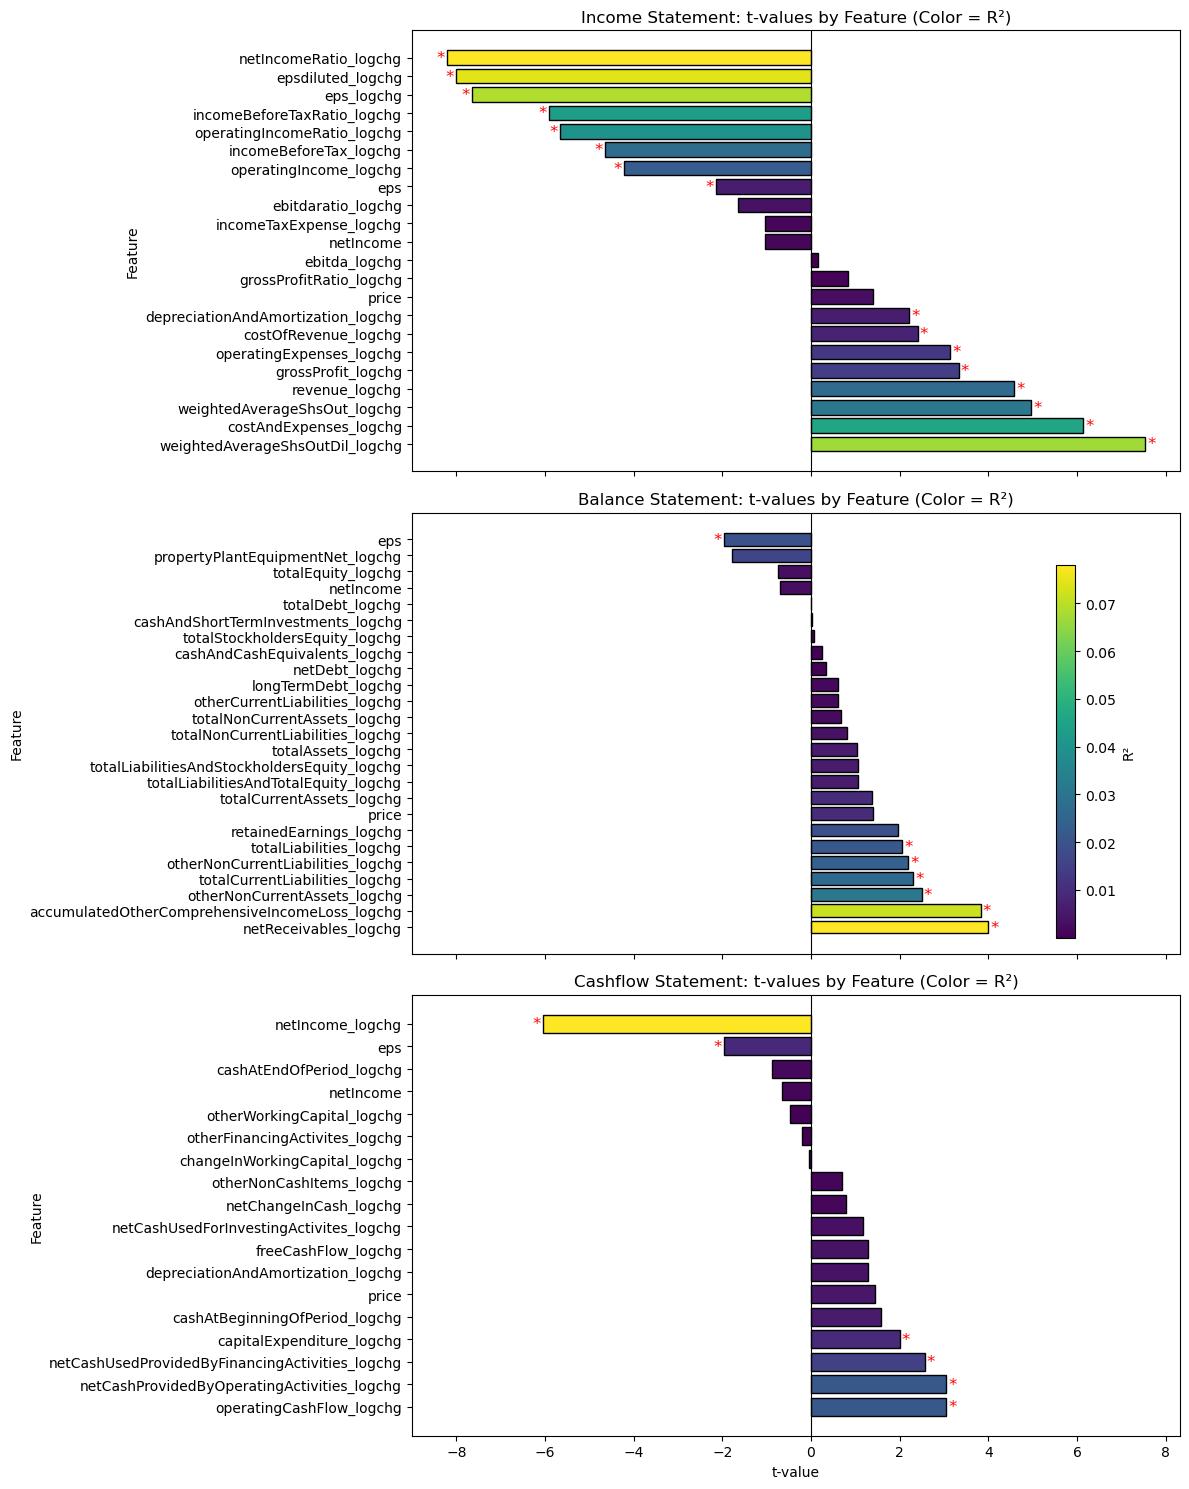

In [64]:
# Combine for convenience, but we’ll split by statement type
plot_df = pd.concat([
    uni_results_income.assign(statement_type='Income'),
    uni_results_balance.assign(statement_type='Balance'),
    uni_results_cashflow.assign(statement_type='Cashflow')
], ignore_index=True)

statement_order = ['Income', 'Balance', 'Cashflow']
n_statements = len(statement_order)

# Create subplots (one per statement type)
fig, axes = plt.subplots(n_statements, 1, figsize=(12, 5*n_statements), sharex=True)

for i, statement in enumerate(statement_order):
    ax = axes[i]
    
    # Subset for this statement
    df = plot_df[plot_df['statement_type'] == statement].copy()
    
    # Sort by absolute t-value descending
    df = df.sort_values('t_value', ascending=False).reset_index(drop=True)
    
    # Normalize r² for color mapping
    norm = mpl.colors.Normalize(vmin=df['r2'].min(), vmax=df['r2'].max())
    cmap = mpl.cm.viridis
    colors = [cmap(norm(val)) for val in df['r2']]
    
    # Y positions
    y_pos = range(len(df))
    
    # Horizontal bar chart
    ax.barh(y=y_pos, width=df['t_value'], color=colors, edgecolor='black')
    
    # Highlight significant features
    for idx, row in enumerate(df.itertuples()):
        if row.reject_null:
            ax.text(
                x=row.t_value + (0.05 if row.t_value>0 else -0.05),
                y=idx,
                s='*',
                va='center',
                ha='left' if row.t_value>0 else 'right',
                color='red',
                fontsize=12
            )
    
    # Y-axis labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['feature'], fontsize=10)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Feature')
    ax.set_title(f'{statement} Statement: t-values by Feature (Color = R²)')

# Shared x-label
axes[-1].set_xlabel('t-value')

# Add a single colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('R²')

plt.tight_layout()
plt.show()


In [74]:
def select_significant_features(statement_df, pe_data_sorted, univariate_results, 
                                t_threshold=1.2, r2_threshold=0.005, p_threshold=0.2, 
                                label=""):
    """
    Merge financial data with log_PE, select significant features, and 
    return only the subset of data for those features.
    """
    # Merge first
    merged = statement_df.merge(pe_data_sorted, on="symbol", how="inner")

    # Filter by thresholds
    signif = univariate_results[
        (univariate_results["t_value"].abs() > t_threshold) &
        (univariate_results["r2"] > r2_threshold) &
        (univariate_results["p_value"] < p_threshold)
    ]

    features = signif["feature"].tolist()
    selected = merged[["symbol", "date", "symbol_date", "log_PE"] + features]

    if label:
        total_features = len(univariate_results)
        n_selected = len(features)
        pct = (n_selected / total_features * 100) if total_features > 0 else 0
        print(f"{label.title()}: {n_selected}/{total_features} features selected ({pct:.1f}%)")

    return selected


In [75]:
signif_income, selected_income = select_significant_features(
    uni_results_income, income_merged, label="income")

signif_balance, selected_balance = select_significant_features(
    uni_results_balance, balance_merged, label="balance")

signif_cashflow, selected_cashflow = select_significant_features(
    uni_results_cashflow, cashflow_merged, label="cashflow")


print(income_selected.shape)
print(balance_selected.shape)
print(cashflow_selected.shape)
print(income_selected.columns)
print(balance_selected.columns)
print(cashflow_selected.columns)

NameError: name 'income_merged' is not defined

In [69]:
def run_pca(df, n_components=None, prefix="", columns=None):
    """
    Run PCA on a DataFrame with optional column selection.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    n_components : int or None
        Number of PCA components. If None, use all available features.
    prefix : str
        Prefix for the PCA component column names.
    columns : list of str or None
        Subset of columns to run PCA on. If None, use all numeric columns
        except common ID columns like symbol/date.

    Returns
    -------
    pd.DataFrame
        DataFrame with PCA component columns added.
    PCA
        The fitted PCA object.
    """

    # Drop common ID columns if present
    exclude_cols = ["symbol", "date", "symbol_date", "log_PE"]

    if columns is None:
        feature_df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    else:
        feature_df = df[columns]

    # Make sure it's numeric
    feature_df = feature_df.select_dtypes(include="number")

    # Handle n_components safely
    max_components = min(feature_df.shape[0], feature_df.shape[1])
    if n_components is None:
        n_components = max_components
    else:
        n_components = min(n_components, max_components)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(feature_df)

    # PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled)

    comp_df = pd.DataFrame(
        components,
        columns=[f"{prefix}{i+1}" for i in range(components.shape[1])],
        index=df.index
    )

    result_df = pd.concat([df, comp_df], axis=1)

    # Print shape
    print(f"PCA Result Shape ({prefix}): {result_df.shape}")

    return result_df, pca


In [70]:
# Income statement PCA
income_df_with_pca, income_pca_model = run_pca(
    income_selected,        # Pass full DataFrame; ID columns are preserved
    n_components=3,
    prefix="income_"
)

# Balance sheet PCA
balance_df_with_pca, balance_pca_model = run_pca(
    balance_selected,
    n_components=3,
    prefix="balance_"
)

# Cash flow PCA
cashflow_df_with_pca, cashflow_pca_model = run_pca(
    cashflow_selected,
    n_components=3,
    prefix="cashflow_"
)


NameError: name 'income_selected' is not defined

In [ ]:
print(income_df_with_pca.columns)
print(balance_df_with_pca.columns)
print(cashflow_df_with_pca.columns)

In [ ]:
import statsmodels.api as sm

def regress_log_pe_on_pca(pca_df, prefix, label=""):
    """
    Run regression of log(PE) on PCA components and return both model + summary.

    Parameters
    ----------
    pca_df : pd.DataFrame
        DataFrame containing PCA components and 'log_PE' column.
    prefix : str
        Prefix for the PCA component names (e.g., 'income_', 'balance_', 'cashflow_').
    label : str, optional
        Label to display in printed output and summary.

    Returns
    -------
    model : statsmodels RegressionResults
        The fitted regression model.
    summary_df : pd.DataFrame
        Compact summary of coefficients, t-values, and p-values.
    """

    # Ensure log_PE exists
    if "log_PE" not in pca_df.columns:
        raise KeyError("'log_PE' column not found in provided DataFrame.")

    # Select PCA columns
    pca_cols = [c for c in pca_df.columns if c.startswith(prefix)]
    X = pca_df[pca_cols]
    y = pca_df["log_PE"]

    # Add intercept
    X = sm.add_constant(X)

    # Run regression
    model = sm.OLS(y, X).fit()

    # Create summary DataFrame
    summary_df = pd.DataFrame({
        "coef": model.params,
        "t_value": model.tvalues,
        "p_value": model.pvalues
    }).reset_index().rename(columns={"index": "variable"})

    if label:
        summary_df["label"] = label
        print(f"{label.title()} PCA Regression:")
        print(f"  Components: {len(pca_cols)}")
        print(f"  Observations: {len(pca_df)}")
        print(f"  R-squared: {model.rsquared:.4f}\n")

    return model, summary_df


In [ ]:
income_model, income_summary = regress_log_pe_on_pca(income_df_with_pca, prefix="income_", label="income")
balance_model, balance_summary = regress_log_pe_on_pca(balance_df_with_pca, prefix="balance_", label="balance")
cashflow_model, cashflow_summary = regress_log_pe_on_pca(cashflow_df_with_pca, prefix="cashflow_", label="cashflow")

In [ ]:
all_pca_summaries = pd.concat([income_summary, balance_summary, cashflow_summary], ignore_index=True)
display(all_pca_summaries)